# **Final project: Generative Face Completion - The Code**
Group 18: DN & HF

---

In this project we are going to reimplement the face completion algorithm proposed by by Yijun Li, Sifei Liu, Jimei Yang and Ming-Hsuan Yang in their paper "Generative Face Completion" (2017) [1] using a deep generative model.

In [0]:
import numpy as np
import random
%load_ext tensorboard
%matplotlib inline
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_addons as tfa
import keras as ks
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import pickle
import math
import torch
import torch.nn as nn

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# **0. The Data**


In [0]:
# Mount Google Drive to get the data.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
############################################
# Downloading the CelebA Images
############################################

# We cropped and preprocessed the CelebA dataset images to 128x128 and uploaded them on our Google Drive. (See Data Preparation Notebook)
path = 'drive/My Drive/Generative Face Completion/'

# Read in the pickle file.
with open(path+'all_images_cropped_converted.pickle', 'rb') as f:
    data = pickle.load(f)

print("Length Training Images: ", len(data))
print("Data Type: ", type(data))
print("Dtype: ", data.dtype)

Length Training Images:  10000
Data Type:  <class 'numpy.ndarray'>
Dtype:  float32


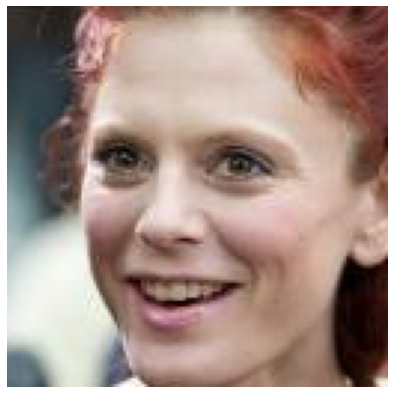

In [0]:
# Show sample image.
plt.figure(figsize=(7,7))
plt.imshow((data[1]+1.0)/2.0)
plt.axis('off')
plt.show()

In [0]:
############################################
# Preparing Training and Testing Data
############################################

# Split our data into training and testing images.
training_images = data[:9000]          # 90%
testing_images =  data[9000:]          # 10%

print("Training Images: ", training_images.shape)
print("Testing Images: ", testing_images.shape)

Training Images:  (9000, 128, 128, 3)
Testing Images:  (1000, 128, 128, 3)


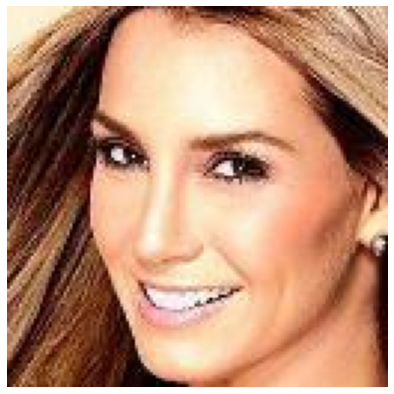

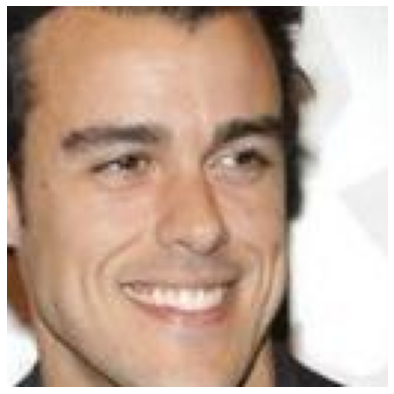

In [0]:
plt.figure(figsize=(7,7))
plt.imshow((training_images[0]+1.0)/2.0)
plt.axis('off')
plt.show()

plt.figure(figsize=(7,7))
plt.imshow((testing_images[0]+1.0)/2.0)
plt.axis('off')
plt.show()

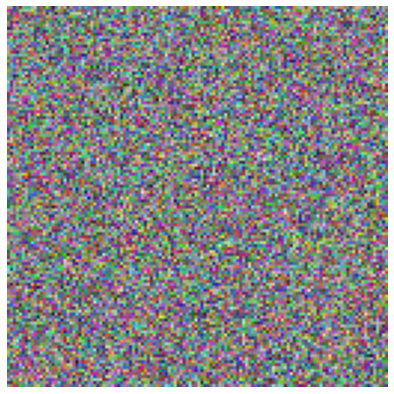

In [0]:
############################################
# The Noise Mask
############################################

# Now we generate a noise image that we will use later for the training images.
noise = np.random.normal(scale=1,size=(128,128,3))
noise = noise.astype(np.float32)

# Preprocess.
noise = tf.nn.sigmoid(noise)
noise = (noise-0.5)*2.0
noise = tf.convert_to_tensor(noise,dtype=np.float32)

# Plot.
plt.figure(figsize=(7,7))
plt.imshow(tf.cast(255*(noise + 1.0)/2.0, tf.uint8))
plt.axis('off')
plt.show()

In [0]:
############################################
# Applying The Noise Mask to Testing Images
############################################

# Get condition array for position of mask for all testing images.
condition_array = np.zeros(shape=[len(testing_images),128,128,3])
# Arrays for saving coordinates of noise masks' upper left corner for each image.
x_s = np.zeros(shape= [len(testing_images), 1])
y_s = np.zeros(shape= [len(testing_images), 1])

for i in range(len(testing_images)):
  # Random upper left corner as start point for noise mask.
  start_x = random.randint(0,64)
  start_y = random.randint(0,64)
  # Saving the coordinates.
  x_s[i] = start_x
  y_s[i] = start_y
  # Generate condition array for current testing image.
  curr_img = np.zeros(shape=[128,128,3], dtype=bool)
  mask = np.ones(shape=[64,64,3], dtype=bool)
  curr_img[start_x:start_x+64,start_y:start_y+64,:] = mask  
  condition_array[i] = curr_img

# Apply masks to get noise testing image.
testing_images = tf.where(condition_array, noise, testing_images)

print("Type after applying mask: ", testing_images.dtype)

Type after applying mask:  <dtype: 'float32'>


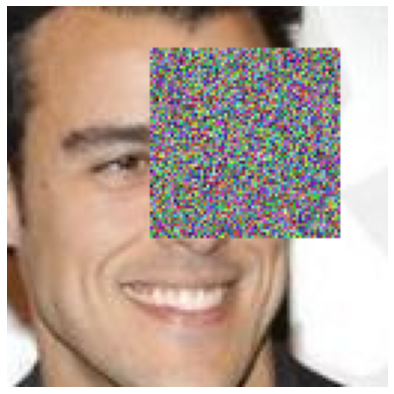

In [0]:
plt.figure(figsize=(7,7))
plt.imshow((testing_images[0]+1.0)/2.0)
plt.axis('off')
plt.show()

# **1. Model**










## 1.1 The Generator

In [0]:
class Generator(tf.keras.layers.Layer):
    
    def __init__(self):
        super(Generator, self).__init__()     
    
        ############################################
        # The encoder
        ############################################

        # First two convolutional layers and one pooling layer:

        self.conv0_1 = tf.keras.layers.Conv2D(
                                filters = 32,
                                kernel_size = 3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros',
                                data_format="channels_last",
                                input_shape = (128,128,3))
        
        self.conv0_2 = tf.keras.layers.Conv2D(
                                filters = 32,
                                kernel_size = 3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')

        self.pool_0 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)

        # "con1" to "pool3" of VGG-19:

        self.conv1_1 = tf.keras.layers.Conv2D(
                                filters = 64, 
                                kernel_size = 3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.conv1_2 = tf.keras.layers.Conv2D(
                                filters = 64,
                                kernel_size = 3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)

        self.conv2_1 = tf.keras.layers.Conv2D(
                                filters = 128,
                                kernel_size = 3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.conv2_2 = tf.keras.layers.Conv2D(
                                filters = 128,
                                kernel_size = 3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)

        self.conv3_1 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.conv3_2 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.conv3_3 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.conv3_4 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.pool_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2)
        
        # Flattening and one fully-connected layer:

        self.flatten = tf.keras.layers.Flatten()

        self.fully_connected = tf.keras.layers.Dense(
                                units=4096,
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')

        ############################################
        # The decoder
        ############################################

        # One fully-connected layer: 

        self.defully_connected = tf.keras.layers.Dense(
                                units=16384,
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')

        # "pool3" to "con1" of VGG-19 but this time with unpooling layers:

        self.upsample_3 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.deconv3_4 = tf.keras.layers.Conv2D(
                                filters=64,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.deconv3_3 = tf.keras.layers.Conv2D(
                                filters=64,
                                kernel_size=3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.deconv3_2 = tf.keras.layers.Conv2D(
                                filters=64,
                                kernel_size=3,
                                padding='SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.deconv3_1 = tf.keras.layers.Conv2D(
                                filters = 128,
                                kernel_size = 3,
                                padding = 'SAME',
                                activation = tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.upsample_2 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.deconv2_2 =  tf.keras.layers.Conv2D(
                                filters=64,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.deconv2_1 = tf.keras.layers.Conv2D(
                                filters=64,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.upsample_1 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.deconv1_2 = tf.keras.layers.Conv2D(
                                filters=64,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.deconv1_1 = tf.keras.layers.Conv2D(
                                filters=32,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        # Lastly, one pooling layer and two convolutional layers:

        self.upsample_0 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.deconv0_2 = tf.keras.layers.Conv2D(
                                filters=32,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.deconv0_1 = tf.keras.layers.Conv2D(
                                filters=32,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        # Reconstruction Layer:

        self.reconstruction_new = tf.keras.layers.Conv2D(
                                filters = 3,
                                kernel_size = 3,
                                padding = "SAME",
                                activation= tf.keras.activations.tanh,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')


    def call(self,x,is_training):
      x = self.conv0_1(x)
      x = self.conv0_2(x)
      x = self.pool_0(x)
      x = self.conv1_1(x)
      x = self.conv1_2(x)
      x = self.pool_1(x)
      x = self.conv2_1(x)
      x = self.conv2_2(x)
      x = self.pool_2(x)
      x = self.conv3_1(x)
      x = self.conv3_2(x)
      x = self.conv3_3(x)
      x = self.conv3_4(x)
      x = self.pool_3(x)
      x = self.flatten(x)
      x = self.fully_connected(x)
      x = self.defully_connected(x)
      x = tf.reshape(x, shape=(2, 8, 8, 256))
      x = self.upsample_3(x)
      x = self.deconv3_4(x)
      x = self.deconv3_3(x)
      x = self.deconv3_2(x)
      x = self.deconv3_1(x)
      x = self.upsample_2(x)
      x = self.deconv2_2(x)
      x = self.deconv2_1(x)
      x = self.upsample_1(x)
      x = self.deconv1_2(x)
      x = self.deconv1_1(x)
      x = self.upsample_0(x)
      x = self.deconv0_2(x)
      x = self.deconv0_1(x)
      x = self.reconstruction_new(x)
      return x


## 1.2 The Discriminator

### 1.2.2 Local Discriminator


In [0]:
class LocalDiscriminator(tf.keras.layers.Layer):

    def __init__(self):
        super(LocalDiscriminator,self).__init__()

        ############################################
        # The local discriminator
        ############################################


        self.conv1_1 = tf.keras.layers.Conv2D(
                                filters = 64,
                                kernel_size = 3,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros'
                                )
        
        self.relu1_1 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv1_2 = tf.keras.layers.Conv2D(
                                filters = 64,
                                kernel_size = 4,
                                strides = 2,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu1_2 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv2_1 = tf.keras.layers.Conv2D(
                                filters = 128,
                                kernel_size = 3,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')

        self.relu2_1 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv2_2 = tf.keras.layers.Conv2D(
                                filters = 128,
                                kernel_size = 4,
                                strides = 2,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')

        self.relu2_2 = tf.keras.layers.ReLU(negative_slope=0.2)

        self.conv3_1 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 3,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')

        self.relu3_1 = tf.keras.layers.ReLU(negative_slope=0.2)

        self.conv3_2 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 4,
                                strides = 2,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')

        self.relu3_2 = tf.keras.layers.ReLU(negative_slope=0.2)

        self.conv4_1 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 3,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu4_1 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv4_2 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 4,
                                strides = 2,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu4_2 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv5 = tf.keras.layers.Conv2D(
                                filters = 1,
                                kernel_size = 4,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                activation = tf.keras.activations.sigmoid,
                                bias_initializer = 'zeros')
        
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=4)
        self.flatten = tf.keras.layers.Flatten()


    def call(self, x, is_training):

        x = self.conv1_1(x)
        x = self.relu1_1(x)
        x = self.conv1_2(x)
        x = self.relu1_2(x)
        x = self.conv2_1(x)
        x = self.relu2_1(x)
        x = self.conv2_2(x)
        x = self.relu2_2(x)
        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv3_2(x)
        x = self.relu3_2(x)
        x = self.conv4_1(x)
        x = self.relu4_1(x)
        x = self.conv4_2(x)
        x = self.relu4_2(x)
        x = self.conv5(x)
        x = self.pool(x)
        x = self.flatten(x)
        #print("Local Disc Output:", x.shape)
        return x



### 1.2.1 Global Discriminator

In [0]:
class GlobalDiscriminator(tf.keras.layers.Layer):
     
    def __init__(self):
        super(GlobalDiscriminator, self).__init__()
        
        ############################################
        # The global discriminator
        ############################################

        self.conv0_1 = tf.keras.layers.Conv2D(
                                filters = 32,
                                kernel_size = 3, 
                                padding="SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu0_1 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv0_2 = tf.keras.layers.Conv2D(
                                filters = 32,
                                kernel_size = 4, 
                                strides=2,
                                padding="SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu0_2 = tf.keras.layers.ReLU(negative_slope=0.2)
          
        self.conv1_1 = tf.keras.layers.Conv2D(
                                filters = 64,
                                kernel_size = 3,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu1_1 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv1_2 = tf.keras.layers.Conv2D(
                                filters = 64,
                                kernel_size = 4,
                                strides=2,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu1_2 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv2_1 = tf.keras.layers.Conv2D(
                                filters = 128,
                                kernel_size = 3,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu2_1 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv2_2 = tf.keras.layers.Conv2D(
                                filters = 128,
                                kernel_size = 4,
                                strides=2,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu2_2 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv3_1 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 3,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu3_1 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv3_2 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 4,
                                strides=2,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu3_2 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv4_1 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 3,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu4_1 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv4_2 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 4,
                                strides=2,
                                padding = "SAME",
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.relu4_2 = tf.keras.layers.ReLU(negative_slope=0.2)
        
        self.conv5 = tf.keras.layers.Conv2D(
                                filters = 1,
                                kernel_size = 4,
                                padding = "SAME",
                                activation = tf.keras.activations.sigmoid,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=4)
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, x, is_training):
        x = self.conv0_1(x)
        x = self.relu0_1(x)
        x = self.conv0_2(x)
        x = self.relu0_2(x)
        x = self.conv1_1(x)
        x = self.relu1_1(x)
        x = self.conv1_2(x)
        x = self.relu1_2(x)
        x = self.conv2_1(x)
        x = self.relu2_1(x)
        x = self.conv2_2(x)
        x = self.relu2_2(x)
        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv3_2(x)
        x = self.relu3_2(x)
        x = self.conv4_1(x)
        x = self.relu4_1(x)
        x = self.conv4_2(x)
        x = self.relu4_2(x)
        x = self.conv5(x)
        x = self.pool(x)
        x = self.flatten(x)
        #print("Global Disc Output:", x.shape)
        return x
  

## 1.3 The Parsing Network


In [0]:
class ParsingNetwork(tf.keras.layers.Layer):
  
    def __init__(self):

        super(ParsingNetwork,self).__init__()

        ############################################
        # The parsing network
        ############################################

        self.conv1_1 = tf.keras.layers.Conv2D(
                                filters = 64,
                                kernel_size = 3,
                                padding = "SAME",
                                input_shape=(128,128,3),
                                activation = tf.keras.activations.relu)
        
        self.conv1_2 = tf.keras.layers.Conv2D(
                                filters = 64,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)

        self.conv2_1 = tf.keras.layers.Conv2D(
                                filters = 128,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
            
        self.conv2_2 = tf.keras.layers.Conv2D(
                                filters = 128,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)

        self.conv3_1 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.conv3_2 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.conv3_3 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)

        self.conv3_4 = tf.keras.layers.Conv2D(
                                filters = 256,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.pool_3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)

        self.conv4_1 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.conv4_2 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.conv4_3 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.conv4_4 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.pool_4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)

        self.conv5_1 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.conv5_2 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.conv5_3 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.conv5_4 = tf.keras.layers.Conv2D(
                                filters = 512,
                                kernel_size = 3,
                                padding = "SAME",
                                activation = tf.keras.activations.relu)
        
        self.pool_5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)

        self.upsample_5 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.deconv_5 = tf.keras.layers.Conv2D(
                                filters=512,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')

        self.upsample_4 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.deconv_4 = tf.keras.layers.Conv2D(
                                filters= 256,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.upsample_3 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.deconv_3 = tf.keras.layers.Conv2D(
                                filters= 128,
                                kernel_size=3,
                                padding='SAME',
                                activation=tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.upsample_2 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.deconv_2 = tf.keras.layers.Conv2D(
                                filters= 64,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')
        
        self.upsample_1 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.deconv_1 = tf.keras.layers.Conv2D(
                                filters= 32,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')

        self.deconv_0 = tf.keras.layers.Conv2D(
                                filters= 17,
                                kernel_size=3,
                                padding='SAME',
                                activation= tf.keras.activations.relu,
                                kernel_initializer = 'he_normal',
                                bias_initializer = 'zeros')


    def call(self, x, is_training):

        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.pool_1(x)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.pool_2(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)
        x = self.pool_3(x)
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.pool_4(x)
        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)
        x = self.conv5_4(x)
        x = self.pool_5(x)
        x = self.upsample_5(x)
        x = self.deconv_5(x)
        x = tf.keras.backend.dropout(x, level=0.5)
        x = self.upsample_4(x)
        x = self.deconv_4(x)
        x = tf.keras.backend.dropout(x, level=0.5)
        x = self.upsample_3(x)
        x = self.deconv_3(x)
        x = tf.keras.backend.dropout(x, level=0.5)
        x = self.upsample_2(x)
        x = self.deconv_2(x)
        x = tf.keras.backend.dropout(x, level=0.5)
        x = self.upsample_1(x)
        x = self.deconv_1(x)
        x = tf.keras.backend.dropout(x, level=0.5)
        x = self.deconv_0(x)
        return x  

# **2. Training**

In [0]:
############################################
# Define the dataset.
############################################

# We will train in batches of 2 as the original paper did.
batch = 2
dataset_real = tf.convert_to_tensor(training_images,dtype=np.float32)
dataset_real = tf.data.Dataset.from_tensor_slices(dataset_real)
dataset_real = dataset_real.shuffle(buffer_size=10000)
dataset_real = dataset_real.batch(batch_size=batch)

## **2.1 Parameters**


In [0]:
############################################
# Initialising models and parameter
############################################

generator = Generator()
local_discriminator = LocalDiscriminator()
global_discriminator = GlobalDiscriminator()

parsing_network = ParsingNetwork()
#parsing_network.load_weights('drive/My Drive/Generative Face Completion/parsing_weights.hdf5')

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999)
local_dis_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
global_dis_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

mulitpliers = {'conv_decode5':1.0, 'conv_decode4': 1.0, 'conv_decode3': 1.0, 'conv_decode2': 1.0, 'conv_decode1': 1.0 }
parsing_optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-4, beta_1=0.9, beta_2=0.999)


## **2.2 Loss Functions**

In [0]:
############################################
# L2 Loss
############################################

def l2_loss(fake, originals):
    fake = tf.cast(fake,dtype=tf.float32)
    originals = tf.cast(originals,dtype=tf.float32)
    loss = tf.nn.l2_loss(fake-originals)
    return loss

############################################
# Adverserial Losses 
############################################

# Define the loss for the generator.
def generator_loss(probabilities):
    # Get only the output probabilities for the fake images.
    probabilities_fake = probabilities[:batch]
    # Create the label vector indicating that the images are correct (=1).
    labels_one = tf.convert_to_tensor(np.ones(shape=(batch,1)))
    labels_one = tf.cast(labels_one, dtype = tf.float32)
    # Use sigmoid cross entropy loss to compute the loss.
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels_one,probabilities_fake)
    # Return loss with weight parameter.
    return loss

# Define the loss for the discriminator.
def discriminator_loss(probabilities):
    # Create the label vector indicating which images are real and which are fake.
    labels_one = tf.convert_to_tensor(np.ones(shape=(batch,1)))
    labels_zero = tf.convert_to_tensor(np.zeros(shape=(batch,1)))
    labels_together = tf.concat([labels_zero, labels_one], axis=0)
    labels_together = tf.cast(labels_together, dtype = tf.float32)
    # Use sigmoid cross entropy loss to compute the loss.
    loss  = tf.nn.sigmoid_cross_entropy_with_logits(labels_together,probabilities)
    # Return loss with weight parameter.
    return loss

############################################
# Parsing Network Loss
############################################

def parsing_loss(labels, probabilities):
    labels = tf.dtypes.cast(labels, tf.int32)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, probabilities)
    return loss

############################################
# Generator Losses
############################################

def local_generator_loss(fake,originals,probabilities_localD):
  loss1 = l2_loss(fake,originals)
  loss2 = generator_loss(probabilities_localD)
  return loss1 + 300 * loss2

def global_generator_loss(fake,originals,probabilities_localD, probabilities_globalD):
  loss1 = l2_loss(fake,originals)
  loss2 = generator_loss(probabilities_localD)
  loss3 = generator_loss(probabilities_globalD)
  return loss1 + 300 * loss2 + 300 * loss3

def parsing_generator_loss(fake,originals,probabilities_localD, probabilities_globalD, labels, probabilities_parsing):
  loss1 = l2_loss(fake,originals)
  loss2 = generator_loss(probabilities_localD)
  loss3 = generator_loss(probabilities_globalD)
  loss4 = parsing_loss(labels,probabilities_parsing)
  return loss1 + 300 * loss2 + 300 * loss3 + 0.005 * loss4



## **2.3 Training the Generator with the Reconstruction Loss (L2) only**

In [0]:
###################################################
# Training Generator with Reconstruction Loss (L2)
###################################################

tf.keras.backend.clear_session()

step=0

for epochs in range(5):

    for img in dataset_real: 
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    
            # Get condition array for position of mask for this batch.
            condition_array = np.zeros(shape=[2,128,128,3])
            start_x = random.randint(0,64)
            start_y = random.randint(0,64)

            for i in range(len(img)):
              curr_img = np.zeros(shape=[128,128,3], dtype=bool)
              mask = np.ones(shape=[64,64,3], dtype=bool)
              curr_img[start_x:start_x+64,start_y:start_y+64,:] = mask  
              condition_array[i] = curr_img

            # Apply mask to get noise image.
            noise_img = tf.where(condition_array, noise, img)

            # Generate fake images with generator.
            fake = generator(noise_img, is_training=True)

            # insert generated part at position of mask into original image.
            inserted_fake = tf.where(condition_array, fake, noise_img)
        
            # Compute loss, compute gradients, apply gradients.
            gen_loss = l2_loss(inserted_fake, img)                                  
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

        ###########################################    
        step += 1

In [0]:
############################################
# Sample Generator Output on Testing Image
############################################

# Show noise image.
plt.figure(figsize=(7,7))
plt.imshow((testing_images[0]+1.0)/2.0)
plt.axis('off')
plt.show()

# Get generated image.
test = generator(testing_images[:2], is_training = False)

# Show generated image.
plt.figure(figsize=(7,7))
plt.imshow((test[0]+1.0)/2.0)
plt.axis('off')
plt.show()

# Insert in original image.
curr_img = np.zeros(shape=[128,128,3], dtype=bool)
mask = np.ones(shape=[64,64,3], dtype=bool)
curr_img[int(x_s[0]):int(x_s[0])+64,int(y_s[0]):int(y_s[0])+64,:] = mask  
condition_array = curr_img

show_img1 = tf.where(condition_array, test[0], testing_images[0])

# Show inserted image.
print("Only L2 Loss:") 
plt.figure(figsize=(7,7))
plt.imshow((show_img1+1.0)/2.0)
plt.axis('off')
plt.show()

## **2.4 Training the Generator with L2 Loss + Local Adversarial Loss (LA1)**

In [0]:
############################################################################
# Training Generator with L2 Loss + Local Adversarial Loss (LA1)
############################################################################

step=0

for epochs in range(5): 

    for img in dataset_real: 
      
        with tf.GradientTape() as gen_tape, tf.GradientTape() as local_dis_tape:
            
            # Get condition array for position of mask for this batch.
            condition_array = np.zeros(shape=[2,128,128,3])
            start_x = random.randint(0,64)
            start_y = random.randint(0,64)

            for i in range(len(img)):
              curr_img = np.zeros(shape=[128,128,3], dtype=bool)
              mask = np.ones(shape=[64,64,3], dtype=bool)
              curr_img[start_x:start_x+64,start_y:start_y+64,:] = mask  
              condition_array[i] = curr_img

            # Apply mask to get noise image.
            noise_img = tf.where(condition_array, noise, img)

            # Generate fake images with generator.
            fake = generator(noise_img, is_training=True)
       
            # Crop the generated image to size and position of mask.
            cropped_fake = tf.image.crop_to_bounding_box(fake, start_x, start_y, 64, 64)

            # Get cropped original for comparison.
            cropped_img = tf.image.crop_to_bounding_box(img, start_x, start_y, 64, 64)
            
            # Concat generated and originial images.
            images = tf.concat([cropped_fake, cropped_img], axis=0)

            # Get output of local discriminator.
            probs = local_discriminator(images,is_training=True)

            # Get losses.
            gen_loss = local_generator_loss(fake, img, probs) 
            local_dis_loss = discriminator_loss(probs)

            # Get gradients.
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            local_dis_gradients = local_dis_tape.gradient(local_dis_loss, local_discriminator.trainable_variables)

            # Apply gradients.
            gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
            local_dis_optimizer.apply_gradients(zip(local_dis_gradients, local_discriminator.trainable_variables))

        ###############################     
        step += 1

In [0]:
############################################
# Sample Generator Output on Testing Image
############################################

# Show noise image.
plt.figure(figsize=(7,7))
plt.imshow((testing_images[0]+1.0)/2.0)
plt.axis('off')
plt.show()

# Get generated image.
testing = generator(testing_images[:2], is_training = False)
#print(testing[0] == test[0])

# Show generated image.
plt.figure(figsize=(7,7))
plt.imshow((testing[0]+1.0)/2.0)
plt.axis('off')
plt.show()

# Insert in original image.
curr_img = np.zeros(shape=[128,128,3], dtype=bool)
mask = np.ones(shape=[64,64,3], dtype=bool)
curr_img[int(x_s[0]):int(x_s[0])+64,int(y_s[0]):int(y_s[0])+64,:] = mask  
condition_array = curr_img

show_img2 = tf.where(condition_array, testing[0], testing_images[0])

# Show inserted image from first training for comparison.
print("Only L2 Loss:") 
plt.figure(figsize=(7,7))
plt.imshow((show_img1+1.0)/2.0)
plt.axis('off')
plt.show()

# Show inserted image from this training.
print("L2 + LA1 Loss:")
plt.figure(figsize=(7,7))
plt.imshow((show_img2+1.0)/2.0)
plt.axis('off')
plt.show()

## **2.5 Training the Generator with L2 + LA1 + Global Adversarial Loss (LA2)**

In [0]:
###########################################################################
# Training Generator with L2 + LA1 + Global Adversarial Loss (LA2)
###########################################################################

step=0

for epochs in range(5):

    for img in dataset_real:
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as global_dis_tape, tf.GradientTape() as local_dis_tape:
           
            # Get condition array for position of mask for this batch.
            condition_array = np.zeros(shape=[2,128,128,3])
            start_x = random.randint(0,64)
            start_y = random.randint(0,64)

            for i in range(len(img)):
              curr_img = np.zeros(shape=[128,128,3], dtype=bool)
              mask = np.ones(shape=[64,64,3], dtype=bool)
              curr_img[start_x:start_x+64,start_y:start_y+64,:] = mask  
              condition_array[i] = curr_img
           
            # Apply mask to get noise image.
            noise_img = tf.where(condition_array, noise, img)

            # Generate fake images with generator.
            fake = generator(noise_img, is_training=True)

            ####### Images for Local Discriminator ################################

            # Crop the generated image to size and position of mask.
            cropped_fake = tf.image.crop_to_bounding_box(fake, start_x, start_y, 64, 64)

            # Get cropped original for comparison.
            cropped_img = tf.image.crop_to_bounding_box(img, start_x, start_y, 64, 64)
            
            # Concat generated and originial images.
            cropped_images = tf.concat([cropped_fake, cropped_img], axis=0)

            #######################################################################
           
            ####### Images for Global Discriminator ################################

            # insert generated part at position of mask into original image.
            inserted_fake = tf.where(condition_array, fake, noise_img)

            # Get originals and concatenate inserted generated and real images.
            images = tf.concat([inserted_fake, img], axis=0)

            ########################################################################

            # Compute output from discriminators.
            probs_local = local_discriminator(cropped_images, is_training=True)
            probs_global = global_discriminator(images, is_training=True)
            
            # Compute loss.
            gen_loss = global_generator_loss(fake, img, probs_local, probs_global)
            global_dis_loss = discriminator_loss(probs_global) 
            local_dis_loss = discriminator_loss(probs_local)
                              
            # compute gradients.
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            global_dis_gradients = global_dis_tape.gradient(global_dis_loss, global_discriminator.trainable_variables)
            local_dis_gradients = local_dis_tape.gradient(local_dis_loss, local_discriminator.trainable_variables)

            # apply gradients.
            gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
            global_dis_optimizer.apply_gradients(zip(global_dis_gradients, global_discriminator.trainable_variables))
            local_dis_optimizer.apply_gradients(zip(local_dis_gradients, local_discriminator.trainable_variables))

        #########################            
        step += 1

In [0]:
############################################
# Sample Generator Output on Testing Image
############################################

# Show noise image.
plt.figure(figsize=(7,7))
plt.imshow((testing_images[0]+1.0)/2.0)
plt.axis('off')
plt.show()

# Get generated image.
test = generator(testing_images[:2], is_training = True)

# Show generated image.
plt.figure(figsize=(7,7))
plt.imshow((test[0]+1.0)/2.0)
plt.axis('off')
plt.show()

# Insert in original image.
curr_img = np.zeros(shape=[128,128,3], dtype=bool)
mask = np.ones(shape=[64,64,3], dtype=bool)
curr_img[int(x_s[0]):int(x_s[0])+64,int(y_s[0]):int(y_s[0])+64,:] = mask  
condition_array = curr_img

show_img3 = tf.where(condition_array, test[0], testing_images[0])

# Show inserted image from first training for comparison.
print("Only L2 Loss:") 
plt.figure(figsize=(7,7))
plt.imshow((show_img1+1.0)/2.0)
plt.axis('off')
plt.show()

# Show inserted image from second training for comparison.
print("L2 + LA1 Loss:")
plt.figure(figsize=(7,7))
plt.imshow((show_img2+1.0)/2.0)
plt.axis('off')
plt.show()

# Show inserted image from this training for comparison.
print("L2 + LA1 + LA2 Loss:")
plt.figure(figsize=(7,7))
plt.imshow((show_img3+1.0)/2.0)
plt.axis('off')
plt.show()

## **2.6 Training the Parsing Network**

In [0]:
################################################################
# Preparing the Annotated CelebA Dataset Images and Labels
################################################################

# We uploaded the annotated dataset to our Google Drive.
path = 'drive/My Drive/Generative Face Completion/'

# Read in the pickle files.
with open(path+'images.pickle', 'rb') as f:
    celeb_images = pickle.load(f)

with open(path+'labels.pickle', 'rb') as f:
    celeb_labels = pickle.load(f)

celeb_images = np.asarray(celeb_images)
celeb_labels = np.asarray(celeb_labels)
celeb_labels = celeb_labels[:,:,:,1]

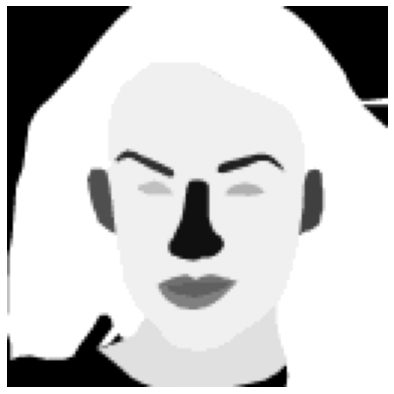

In [0]:
# Show sample label.
vis = celeb_labels[0]
plt.figure(figsize=(7,7))
plt.imshow((vis+1.0)/2.0, cmap='gray')
plt.axis('off')
plt.show()

In [0]:
###################################################
# Preparing Input for Parsing Network
###################################################
celeb_dataset = celeb_images

# We will train in batches of 2 as the original paper did.
batch = 2
celeb_dataset = tf.convert_to_tensor(celeb_dataset,dtype=np.float32)
celeb_dataset = tf.data.Dataset.from_tensor_slices(celeb_dataset)
celeb_dataset = celeb_dataset.batch(batch_size=batch)

In [0]:
###################################################
# Training the Parsing Network with Celeb Dataset
###################################################

step=0

for epochs in range(30):

    batch_number = 0

    for image in celeb_dataset:
        
        with tf.GradientTape() as parsing_tape:

            # Compute output from parsing network.
            probs = parsing_network(image, is_training=True)

            # Get corresponding labels for this batch.
            labels = celeb_labels[batch_number:batch_number+2] 

            # Compute loss, compute gradients, apply gradients, store summaries.
            pars_loss = parsing_loss(labels, probs)
            parsing_gradients = parsing_tape.gradient(pars_loss, parsing_network.trainable_variables)
            parsing_optimizer.apply_gradients(zip(parsing_gradients, parsing_network.trainable_variables))
            
        step += 1
        batch_number += 2

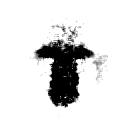

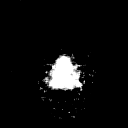

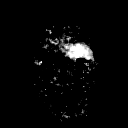

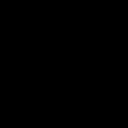

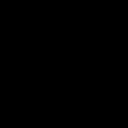

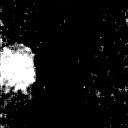

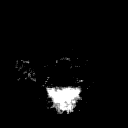

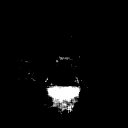

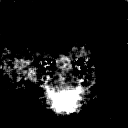

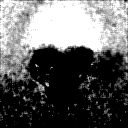

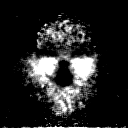

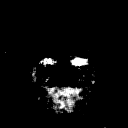

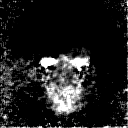

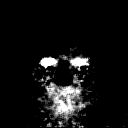

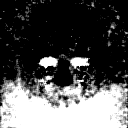

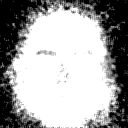

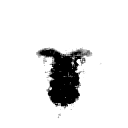

In [0]:
celeb_images = tf.cast(celeb_images, dtype = 'float32')
parsing_test = parsing_network(celeb_images[1000:1002], is_training=False)
parsing_test = np.asarray(parsing_test)

# Show parsing results.
for i in range(17):
  vis = parsing_test[0,:,:,i]
  cv2_imshow(vis*100)

## **2.7 Training the Generator with L2 + LA1 + LA2 + Parsing Loss**

In [0]:
####################################################################
# Getting Parsing Result of the Parsing Network with CelebA Dataset
####################################################################

parsing_CelebA = np.zeros(shape=(1,128,128,17))
for batch in dataset_real:
    output = parsing_network(batch, is_training=False)
    parsing_CelebA = np.append(parsing_CelebA, output, axis=0)

parsing_CelebA = np.delete(parsing_CelebA,0,axis=0)

####################################################################
# Training the Generator with L2 + LA1 + LA2 + Parsing Loss
####################################################################

step=0

for epochs in range(3):

    batch_number = 0

    for img in dataset_real:
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as global_dis_tape, tf.GradientTape() as local_dis_tape:
          
            # Get condition array for position of mask for this batch.
            condition_array = np.zeros(shape=[2,128,128,3])
            start_x = random.randint(0,64)
            start_y = random.randint(0,64)

            for i in range(len(img)):
              curr_img = np.zeros(shape=[128,128,3], dtype=bool)
              mask = np.ones(shape=[64,64,3], dtype=bool)
              curr_img[start_x:start_x+64,start_y:start_y+64,:] = mask  
              condition_array[i] = curr_img
           
            # Apply mask to get noise image.
            noise_img = tf.where(condition_array, noise, img)

            # Generate fake images with generator.
            fake = generator(noise_img, is_training=True)

            ####### Images for Local Discriminator ################################

            # Crop the generated image to size and position of mask.
            cropped_fake = tf.image.crop_to_bounding_box(fake, start_x, start_y, 64, 64)

            # Get cropped original for comparison.
            cropped_img = tf.image.crop_to_bounding_box(img, start_x, start_y, 64, 64)
            
            # Concat generated and originial images.
            cropped_images = tf.concat([cropped_fake, cropped_img], axis=0)

            #######################################################################
           
            ####### Images for Global Discriminator ################################

            # insert generated part at position of mask into original image.
            inserted_fake = tf.where(condition_array, fake, noise_img)

            # Get originals and concatenate inserted generated and real images.
            images = tf.concat([inserted_fake, img], axis=0)

            ########################################################################

            # Compute output from discriminators.
            probs_local = local_discriminator(cropped_images, is_training=True)
            probs_global = global_discriminator(images, is_training=True)
           
            # Compute output from parsing network.
            probs_parsing = parsing_network(inserted_fake, is_training=False)
            
            # Compute loss.
            gen_loss = parsing_generator_loss(fake, img, probs_local, probs_global, parsing_CelebA[batch_number:batch_number+2], probs_parsing)
            global_dis_loss = discriminator_loss(probs_global) 
            local_dis_loss = discriminator_loss(probs_local)
                              
            # compute gradients.
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            global_dis_gradients = global_dis_tape.gradient(global_dis_loss, global_discriminator.trainable_variables)
            local_dis_gradients = local_dis_tape.gradient(local_dis_loss, local_discriminator.trainable_variables)

            # apply gradients.
            gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
            global_dis_optimizer.apply_gradients(zip(global_dis_gradients, global_discriminator.trainable_variables))
            local_dis_optimizer.apply_gradients(zip(local_dis_gradients, local_discriminator.trainable_variables))

        batch_number += 2     
        step += 1

In [0]:
############################################
# Sample Generator Output on Testing Image
############################################

# Show noise image.
plt.figure(figsize=(7,7))
plt.imshow((testing_images[0]+1.0)/2.0)
plt.axis('off')
plt.show()

# Get generated image.
test = generator(testing_images[:2], is_training = True)

# Show generated image.
plt.figure(figsize=(7,7))
plt.imshow((test[0]+1.0)/2.0)
plt.axis('off')
plt.show()

# Insert in original image.
curr_img = np.zeros(shape=[128,128,3], dtype=bool)
mask = np.ones(shape=[64,64,3], dtype=bool)
curr_img[int(x_s[0]):int(x_s[0])+64,int(y_s[0]):int(y_s[0])+64,:] = mask  
condition_array = curr_img

show_img4 = tf.where(condition_array, test[0], testing_images[0])

# Show inserted image from first training for comparison.
print("Only L2 Loss:") 
plt.figure(figsize=(7,7))
plt.imshow((show_img1+1.0)/2.0)
plt.axis('off')
plt.show()

# Show inserted image from second training for comparison.
print("L2 + LA1 Loss:")
plt.figure(figsize=(7,7))
plt.imshow((show_img2+1.0)/2.0)
plt.axis('off')
plt.show()

# Show inserted image from third training for comparison.
print("L2 + LA1 + LA2 Loss:")
plt.figure(figsize=(7,7))
plt.imshow((show_img3+1.0)/2.0)
plt.axis('off')
plt.show()

# Show inserted image from this training for comparison.
plt.figure(figsize=(7,7))
plt.imshow((show_img4+1.0)/2.0)
plt.axis('off')
plt.show()

# **3. Testing**

Code for saving testing results, not needed to be executed.

In [0]:
###################################################
# Preparing Input for Testing
###################################################

batch = 2
dataset_test = tf.convert_to_tensor(testing_images,dtype=np.float32)
dataset_test = tf.data.Dataset.from_tensor_slices(dataset_test)
dataset_test = dataset_test.batch(batch_size=batch)
print(dataset_test)

In [0]:
###################################################
# Get Sample Results from Testing Images
###################################################

output_test = np.zeros(shape=(1,128,128,3))
for batch in dataset_test:
    output = generator(batch, is_training=False)
    output_test = np.append(output_test, output, axis=0)

output_test = np.delete(output_test,0,axis=0)

for i in range(1000):
    curr_img = np.zeros(shape=[128,128,3], dtype=bool)
    mask = np.ones(shape=[64,64,3], dtype=bool)
    curr_img[int(x_s[i]):int(x_s[i])+64,int(y_s[i]):int(y_s[i])+64,:] = mask  
    condition_array = curr_img

    img = tf.where(condition_array, output_test[i], testing_images[i])
    output_test[i] = img

In [0]:
# Show sammple images.
for i in range(20):
  plt.figure(figsize=(5,5))
  plt.imshow((output_test[i]+1.0)/2.0)
  plt.axis('off')
  plt.show()

In [0]:
###################################################
# Saving the Images on Google Drive
###################################################

# Save the array as a pickle file.
with open('results_XXX.pickle', 'wb') as f:
    pickle.dump(output_test, f)

# Copy to google drive.
!cp results_XXX.pickle drive/My\ Drive/

## **3.1 Qualitative Results**

In [0]:
# We uploaded the annotated dataset to our Google Drive.
path = 'drive/My Drive/Generative Face Completion/'

# Read in the pickle files.
with open(path+'L2only.pickle', 'rb') as f:
    results_L2 = pickle.load(f)

with open(path+'L2andLA1.pickle', 'rb') as f:
    results_L2_LA1 = pickle.load(f)

with open(path+'L2andLA1andLA2.pickle', 'rb') as f:
    results_L2_LA1_LA2 = pickle.load(f)

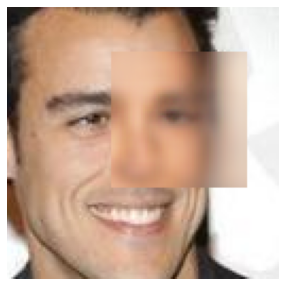

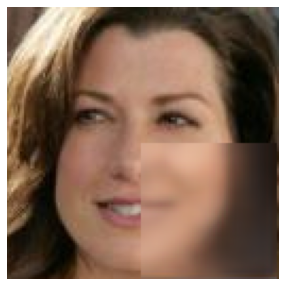

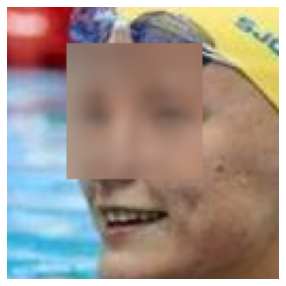

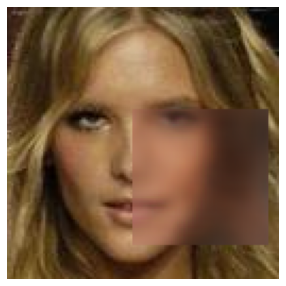

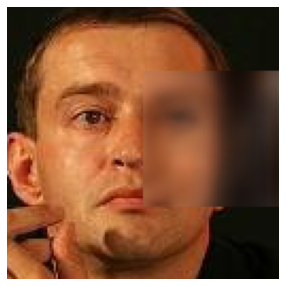

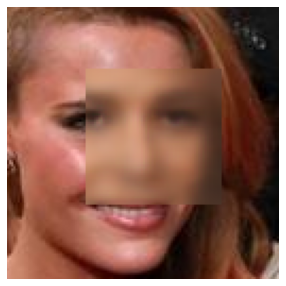

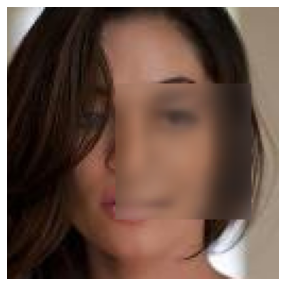

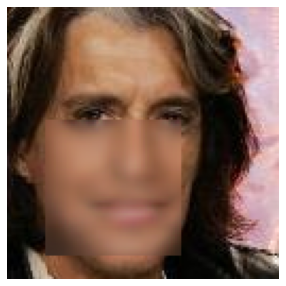

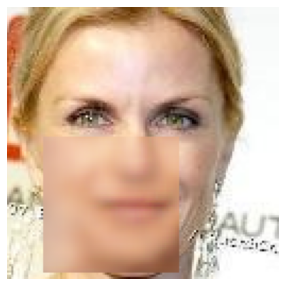

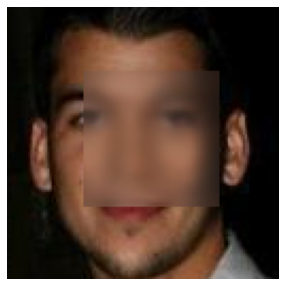

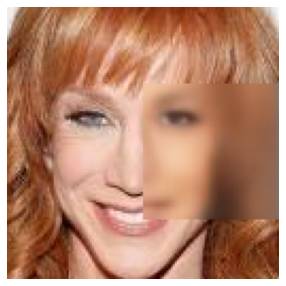

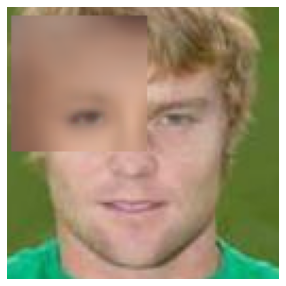

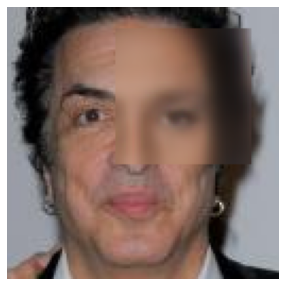

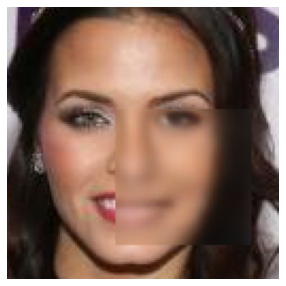

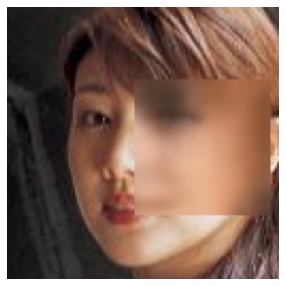

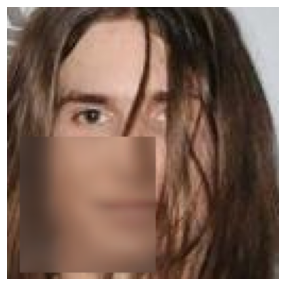

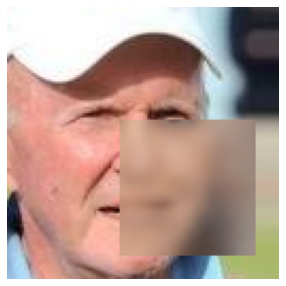

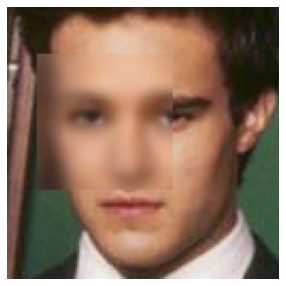

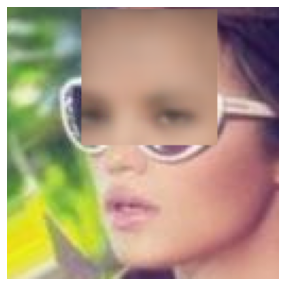

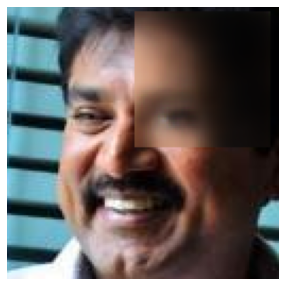

In [0]:
###############################################
# Results on Testing Image with L2 Loss Only
###############################################

# Show sammple images.
for i in range(20):
  plt.figure(figsize=(5,5))
  plt.imshow((results_L2[i]+1.0)/2.0)
  plt.axis('off')
  plt.show()

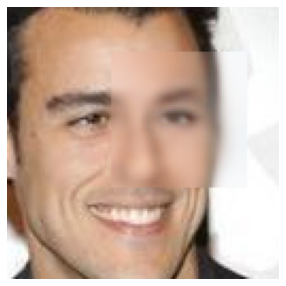

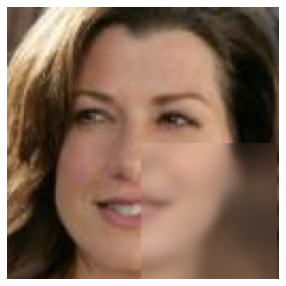

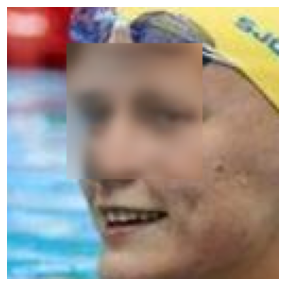

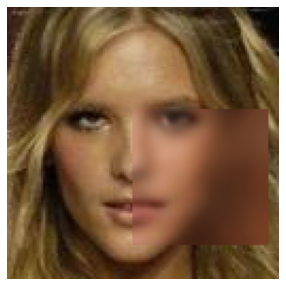

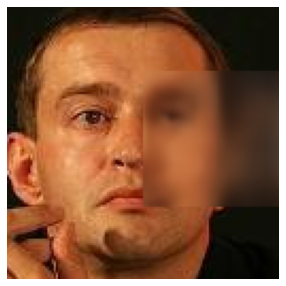

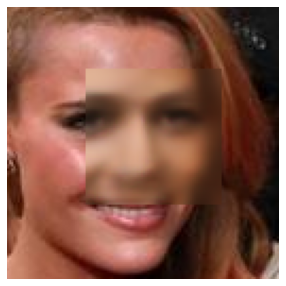

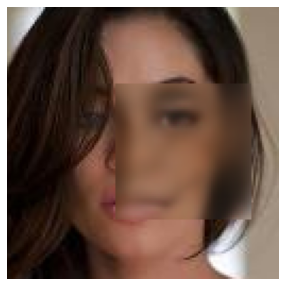

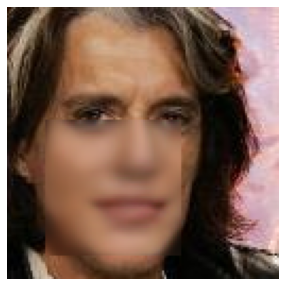

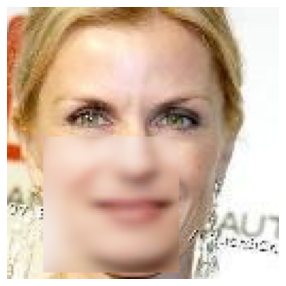

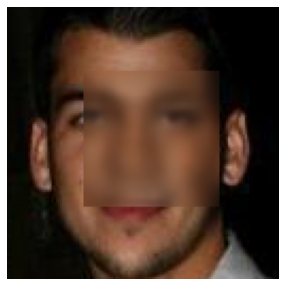

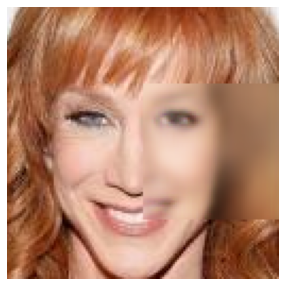

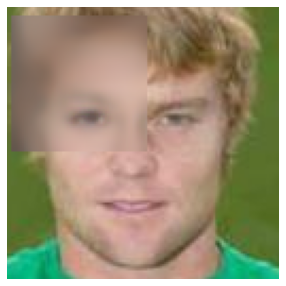

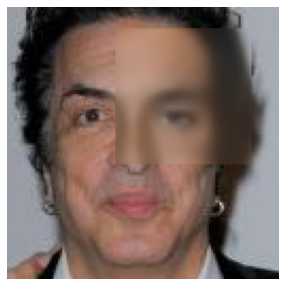

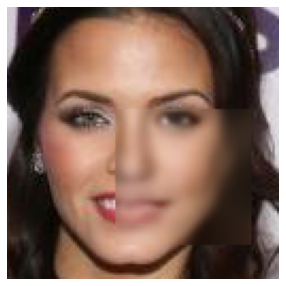

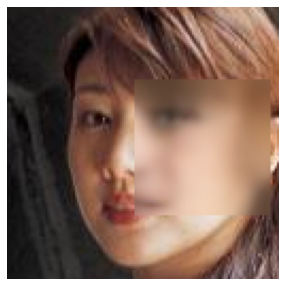

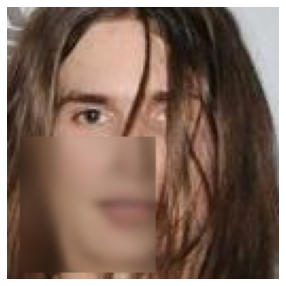

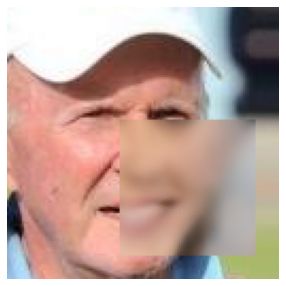

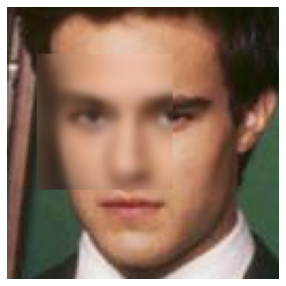

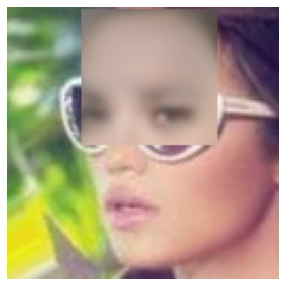

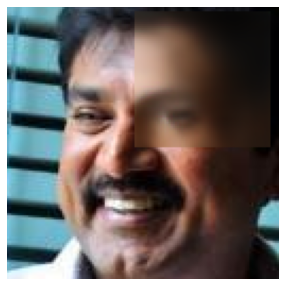

In [0]:
########################################################
# Results on Testing Image with L2 Loss and LA1 Loss
########################################################

# Show sammple images.
for i in range(20):
  plt.figure(figsize=(5,5))
  plt.imshow((results_L2_LA1[i]+1.0)/2.0)
  plt.axis('off')
  plt.show()

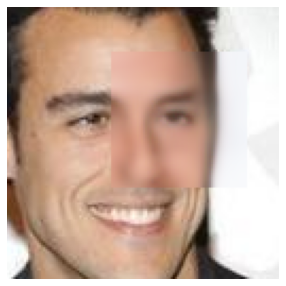

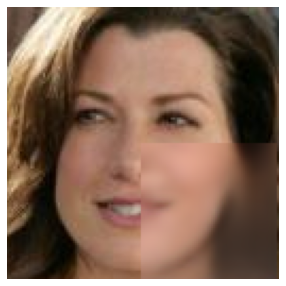

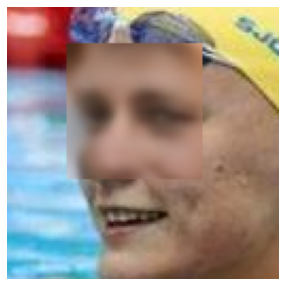

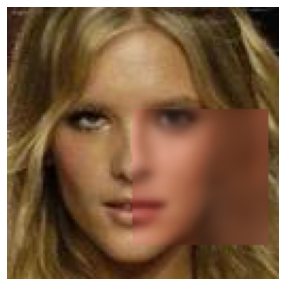

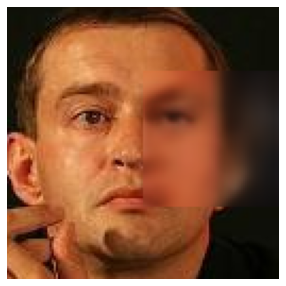

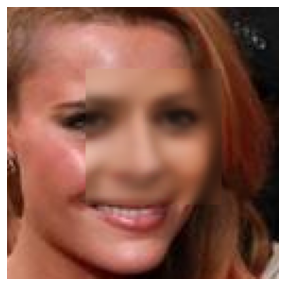

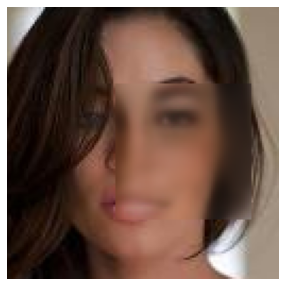

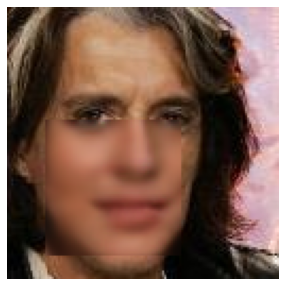

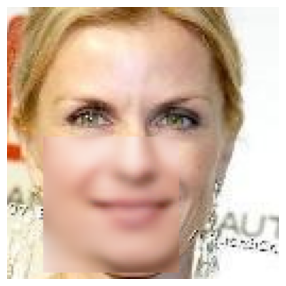

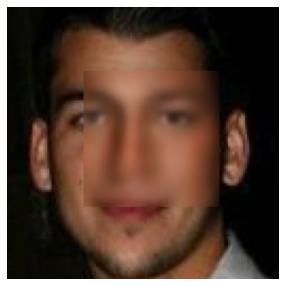

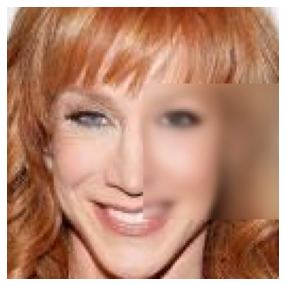

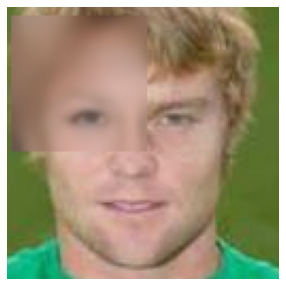

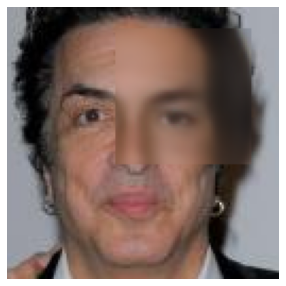

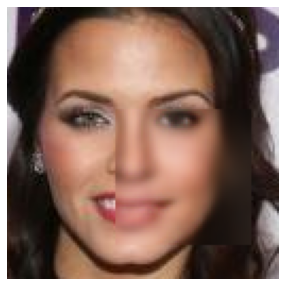

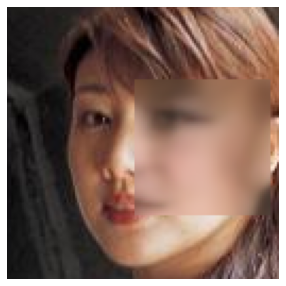

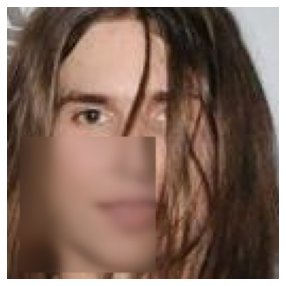

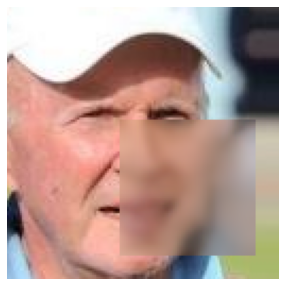

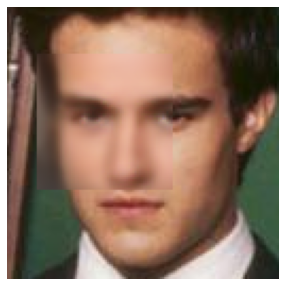

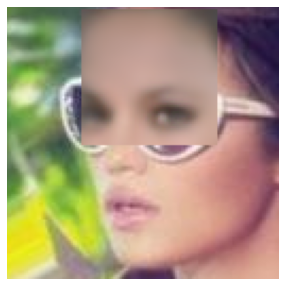

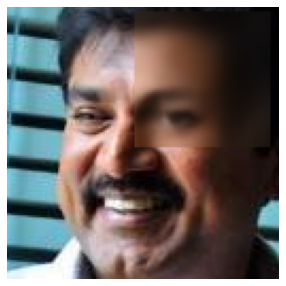

In [0]:
###############################################################
# Results on Testing Image with L2 Loss, LA1 Loss and LA2 Loss
###############################################################

# Show sammple images.
for i in range(20):
  plt.figure(figsize=(5,5))
  plt.imshow((results_L2_LA1_LA2[i]+1.0)/2.0)
  plt.axis('off')
  plt.show()

## **3.2 Quantitative Results**

In [0]:
##################################################################################
# PSNR Difference between Completed Testing Images and Original Testing Images
##################################################################################

##### Only L2 Loss ######################################################################

psnr_L2 = np.zeros(shape=[1000,1])

for i in range(1000):
    psnr = tf.image.psnr(testing_images[i], results_L2[i], max_val = 2.0, name=None)
    psnr_L2[i] = psnr

avg_psnr_L2 = np.average(psnr_L2)

##### L2 Loss + LA1 Loss ################################################################

psnr_L2_LA1 = np.zeros(shape=[1000,1])

for i in range(1000):
    psnr = tf.image.psnr(testing_images[i], results_L2_LA1[i], max_val = 2.0, name=None)
    psnr_L2_LA1[i] = psnr

avg_psnr_L2_LA1 = np.average(psnr_L2_LA1)

##### L2 Loss + LA1 Loss + LA2 Loss #####################################################

psnr_L2_LA1_LA2 = np.zeros(shape=[1000,1])

for i in range(1000):
    psnr = tf.image.psnr(testing_images[i], results_L2_LA1_LA2[i], max_val = 2.0, name=None)
    psnr_L2_LA1_LA2[i] = psnr

avg_psnr_L2_LA1_LA2 = np.average(psnr_L2_LA1_LA2)

##########################################################################################

print("PSNR L2: ", avg_psnr_L2)
print("PSNR L2 + LA1: ", avg_psnr_L2_LA1)
print("PSNR L2 + LA1 + LA2: ", avg_psnr_L2_LA1_LA2)

PSNR L2:  15.70794813156128
PSNR L2 + LA1:  15.712812992095948
PSNR L2 + LA1 + LA2:  16.360365723609924


In [0]:
##################################################################################
# SSIM Similarity between Completed Testing Images and Original Testing Images
##################################################################################

# Convert to tensor.
results_L2 = tf.convert_to_tensor(results_L2,dtype=np.float32)
results_L2_LA1 = tf.convert_to_tensor(results_L2_LA1,dtype=np.float32)
results_L2_LA1_LA2 = tf.convert_to_tensor(results_L2_LA1_LA2,dtype=np.float32)

# Calculate SSIM for different training levels.
ssim_L2 = tf.image.ssim(testing_images, results_L2, max_val = 2.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
ssim_L2_LA1 = tf.image.ssim(testing_images, results_L2_LA1, max_val = 2.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
ssim_L2_LA1_LA2 = tf.image.ssim(testing_images, results_L2_LA1_LA2, max_val = 2.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)

# Convert to numpy array.
ssim_L2 = np.asarray(ssim_L2)
ssim_L2_LA1 = np.asarray(ssim_L2_LA1)
ssim_L2_LA1_LA2 = np.asarray(ssim_L2_LA1_LA2)

# Calculate average.
avg_ssim_L2 = np.average(ssim_L2)
avg_ssim_L2_LA1 = np.average(ssim_L2_LA1)
avg_ssim_L2_LA1_LA2 = np.average(ssim_L2_LA1_LA2)

# Print results.
print("SSIM L2: ", avg_ssim_L2)
print("SSIM L2 + LA1: ", avg_ssim_L2_LA1)
print("SSIM L2 + LA1 + LA2: ", avg_ssim_L2_LA1_LA2)

SSIM L2:  0.5717871
SSIM L2 + LA1:  0.5818181
SSIM L2 + LA1 + LA2:  0.6773577
